In [1]:

import asset_loader

from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from tqdm import tqdm
import itertools


from importlib import reload

c:\Users\otkul\sintef\repo\QAOA\examples\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


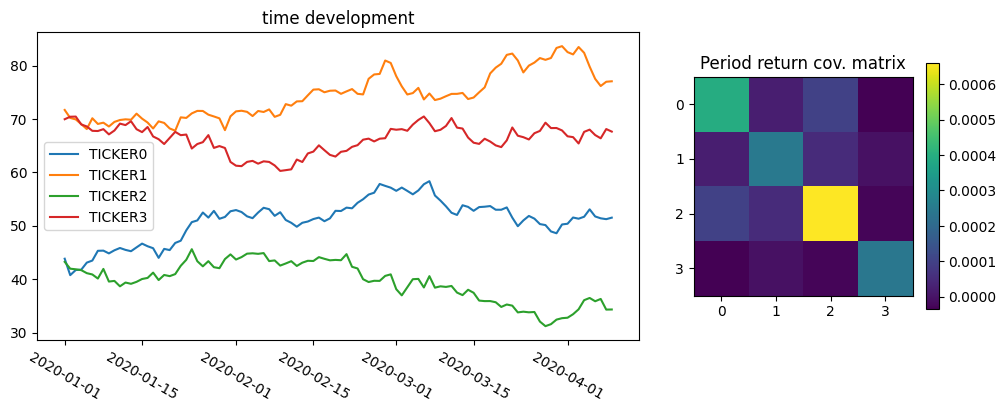

In [2]:
reload(asset_loader)
assets = asset_loader.AssetData(4, 100, seed=13)
assets.plotAssets()

params = {
    "risk" : 0.5,
    "budget": 2,
    "penalty": 4,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return,
    "usebarrier": True #only for drawing
}

In [3]:
from qaoa import QAOA, problems, mixers

qaoa_portopt = QAOA(
    problem=problems.PortfolioOptimization,
    mixer=mixers.Grover,
    params=params
)

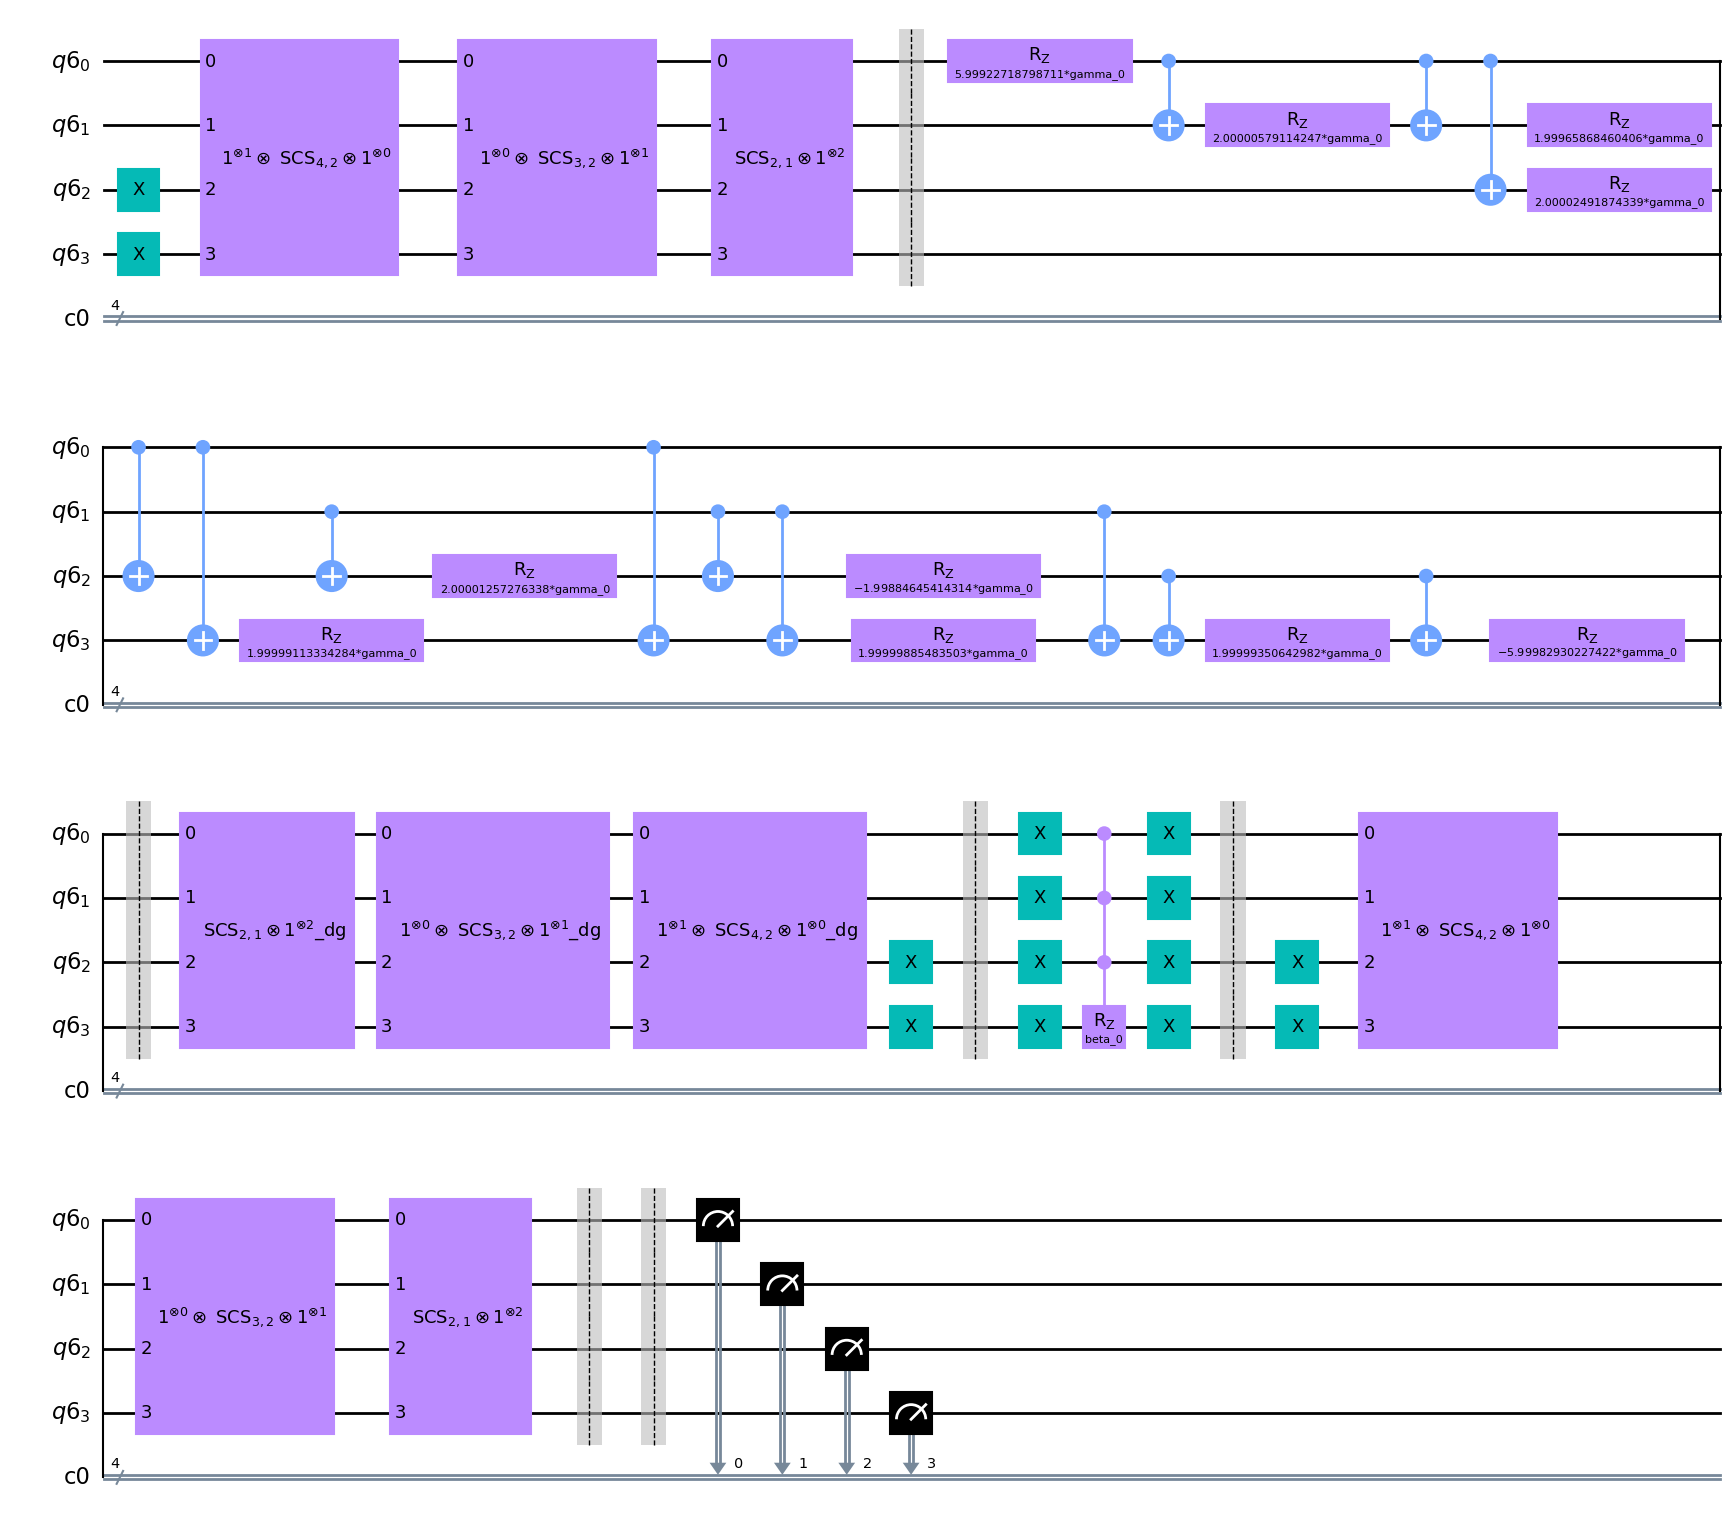

In [4]:
qaoa_portopt.createParameterizedCircuit(1)
display(qaoa_portopt.parameterized_circuit.draw(output='mpl'))


In [ ]:
tril_cov = np.tril(qaoa_portopt.cov_matrix + np.tril(qaoa_portopt.cov_matrix, k=-1))
plt.imshow(tril_cov)
print(np.sum(qaoa_portopt.cov_matrix, axis=0))
print(np.sum(tril_cov, axis=0))

x = np.random.rand(4)
print(x.T@(qaoa_portopt.cov_matrix@x))
print(x@(qaoa_portopt.cov_matrix@x))
print(x.T@(tril_cov@x))

print(np.ones((3)))

In [ ]:
print(qaoa_portopt.isFeasible("0010"))
print(qaoa_portopt.cost("0010"))
print(qaoa_portopt.cost("0101"))
print(qaoa_portopt.cost("1100"))

print(qaoa_portopt.cost("1000"))



In [ ]:

print("solutions:")
best_sol = None
best_cost = None
for s in [''.join(i) for i in itertools.product('01', repeat = assets.N)]:
    c = qaoa_portopt.cost(s)
    if best_sol is None:
        best_sol = s
        best_cost = c
    elif c > best_cost:
        best_sol = s
        best_cost = c

    if qaoa_portopt.isFeasible(s):
        print(s, c)
    else: 
        print(s, '\t', c)

print("--------------------")
print("Best sol is "+ best_sol + " with cost " + str(best_cost))

## Sample cost landscape

In [ ]:
qaoa_portopt.sample_cost_landscape(angles={"gamma": [0,np.pi,50], "beta": [0,np.pi,40]})

In [ ]:
def plotLandscape(field, title, interpolation='bicubic'):
    f = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    _=plt.xlabel(r'$\gamma$')
    _=plt.ylabel(r'$\beta$')
    ax = plt.gca()
    _=plt.title(title)
    im = ax.imshow(field, interpolation=interpolation, origin='lower', extent=[0,np.pi,0,np.pi])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _=plt.colorbar(im, cax=cax)

plotLandscape(qaoa_portopt.E, "Expection value", interpolation="None")
#plotLandscape(qaoa_portopt.E, r'CVaR with $\alpha$='+str(qaoaec_cvar.params["alpha"])) #, interpolation="None")
plotLandscape(qaoa_portopt.Var, "Variance")


In [ ]:
maxdepth=7
for i in tqdm(range(maxdepth)):
    qaoa_portopt.increase_depth()

In [ ]:
hist=qaoa_portopt.hist(qaoa_portopt.angles_hist['d'+str(maxdepth)+'_final'])
plot_histogram(hist)

In [ ]:
sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

for s, freq in sorted_hist.items():
    if qaoa_portopt.isFeasible(s):
        print(qaoa_portopt.cost(s), s, freq)
    else:
        print("\t", qaoa_portopt.cost(s), s, freq)

print("Classical best result: ", (best_sol, best_cost))